<div style="text-align: center;">
<a target="_blank" href="https://colab.research.google.com/github/bmalcover/aa_2425/blob/main/10_VGG_Custom_Dataset/VGG_Custom.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

In [2]:
import os

import torch
import torch.optim as optim
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import cv2

# Introducció

En aquesta pràctica, treballarem amb un conjunt de dades d'imatges de cans i moixos que ja heu utilitzat a la pràctica de la part anterior de l'assignatura. Tot i que coneixem aquest conjunt de dades, en aquesta ocasió ho em d'emprar amb ``Pytorch`` per tant haurem d'adaptar com ho llegim: fent un pre-processat de les dades per aplicar-los nous models d'aprenentatge profund.

L'objectiu de la sessió serà experimentar amb les diferents versions de la xarxa de convolució ``VGG``, com ara VGG16 i VGG19. Aquesta pràctica us permetrà veure com canvien els resultats d'entrenament i predicció en funció de l'arquitectura emprada, i reflexionar sobre els avantatges i inconvenients d'incrementar la profunditat d'una xarxa de convolució.

# Preparam les dades
Primerament descarregam les dades en el Google Colab. Per tal de fer-ho emprarem les eines ``wget`` i ``unzip``.


In [3]:
!wget https://github.com/bmalcover/aa_2425/releases/download/v1/gatigos.zip
!unzip gatigos.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: annotations/Cats_Test3132.xml  
  inflating: annotations/Cats_Test3133.xml  
  inflating: annotations/Cats_Test3134.xml  
  inflating: annotations/Cats_Test3135.xml  
  inflating: annotations/Cats_Test3136.xml  
  inflating: annotations/Cats_Test3137.xml  
  inflating: annotations/Cats_Test3138.xml  
  inflating: annotations/Cats_Test3139.xml  
  inflating: annotations/Cats_Test314.xml  
  inflating: annotations/Cats_Test3140.xml  
  inflating: annotations/Cats_Test3141.xml  
  inflating: annotations/Cats_Test3142.xml  
  inflating: annotations/Cats_Test3143.xml  
  inflating: annotations/Cats_Test3144.xml  
  inflating: annotations/Cats_Test3145.xml  
  inflating: annotations/Cats_Test3146.xml  
  inflating: annotations/Cats_Test3147.xml  
  inflating: annotations/Cats_Test3148.xml  
  inflating: annotations/Cats_Test3149.xml  
  inflating: annotations/Cats_Test315.xml  
  inflating: annotations/Cats_Test3150.xm

# *Custom dataset*

Un dataset personalitzat en PyTorch permet preparar i gestionar dades específiques per a un projecte d’aprenentatge automàtic. La classe ``Dataset`` de ``PyTorch`` és la base per crear aquest tipus de dataset i requereix la implementació de tres mètodes essencials: ``__init__``, ``__len__``, i ``__getitem__``.

* ``__init__``: Aquest mètode inicialitza el ``dataset`` i defineix els paràmetres que seran necessaris, com ara la ubicació de les dades o qualsevol transformació a aplicar. Aquí es poden carregar rutes d'imatges o etiquetes i definir les transformacions que es realitzaran.

* ``__len__``: Aquest mètode retorna el nombre total d'exemples en el ``dataset``. ``PyTorch`` l'utilitza per saber quantes mostres conté el conjunt de dades, cosa que és essencial per crear les batchs d’entrenament.
* ``__getitem__``: Aquest mètode accedeix a una mostra concreta del ``dataset``, identificada per un índex, i retorna les dades i la seva etiqueta (o ``target``). Normalment, s’apliquen les transformacions aquí abans de retornar la mostra, per assegurar que cada dada té el format adequat per al model.

Un cop creada, aquesta classe es pot emprar amb el ``DataLoader`` de ``PyTorch`` per gestionar l'entrenament en *batchs*, fent que el dataset personalitzat sigui eficient i fàcil de treballar dins del flux d’aprenentatge automàtic de ``PyTorch``.


In [4]:
class CatIGosDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, img_paths, annotations, transform=None):
        """

        Args:
            path:
            path_anotation:
            transform:
        """
        super().__init__()
        self.img_paths = img_paths
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_paths[idx])
        label = self.annotations[self.img_paths[idx]]

        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
import glob

paths_imgs = glob.glob("./images/*.png")
labels = {}

for path_img in paths_imgs:
    _, name = os.path.split(path_img)
    name = name.split(".")[0]

    name_xml = f"./annotations/{name}.xml"
    tree = ET.parse(name_xml)
    root = tree.getroot()

    annotation = root.find('object').find('name').text
    annotation = 0 if annotation == 'cat' else 1

    labels[path_img] = annotation

In [6]:
train, test = train_test_split(paths_imgs, random_state=42, test_size=0.25)

In [7]:
BATCH_SIZE = 4
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = CatIGosDataset(train, labels, transform=transform)
test_ds = CatIGosDataset(test, labels, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)

In [8]:
img, target = next(iter(train_loader))
print(img.shape, target)

torch.Size([4, 3, 256, 256]) tensor([1, 0, 1, 1])


# Definicio de la xarxa: VGG i *Transfer learning*

En aquesta pràctica aplicarem la tècnica de transfer learning amb una de les xarxes CNN més conegudes i profundes:

 - VGG. [Very Deep Convolutional Networks for Large-Scale Image Recognition, 2014](https://arxiv.org/abs/1409.1556). La mida d'entrada de les imatges és de (224x224x3). VGG es presenta en diferents variants, com ara VGG16 i VGG19, que contenen respectivament 16 i 19 capes amb aproximadament 138 milions de paràmetres entrenables en el cas de VGG16.

Descarregarem VGG i l'analitzarem. En aquest cas, no només obtenim la seva arquitectura, sinó també els pesos resultants del seu entrenament en grans conjunts de dades.





In [38]:
vgg11 = models.vgg11(weights=True)

print("-" * 50)
print("Arquitectura VGG11")
print("-" * 50)
print(vgg11)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


--------------------------------------------------
Arquitectura VGG11
--------------------------------------------------
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

## Com emprar la GPU per entrenar un model

Un dels elements diferencials d'aquest model, respecte als que havíem vist fins ara, és la seva mida i, per tant, l'entrenament es torna impossible emprant __CPU__ directament. Per resoldre-ho hem d'emprar una **GPU**, a Google Colab disposam d'elles gratuïtament. Per fer-ho amb *Pytorch* hem de fer tres passes:

1. Comprovar que hi ha una GPU disponible.
2. Moure el model a GPU.
3. Moure les dades a GPU.

### Comprova si tenim una GPU disponible

Primer de tot, cal verificar si hi ha una GPU disponible a l’entorn. Això es pot fer amb el següent codi:

```python

import torch

is_cuda = torch.cuda.is_available()
```

Si la variable ``is_cuda`` és certa, llavors tens accés a una GPU.

### Mou el model a la GPU

En PyTorch, els models han d'estar explícitament en la GPU per poder fer servir la seva potència de càlcul. Si estàs carregant un model preentrenat (com AlexNet, ResNet, etc.), o si has definit el teu propi model, pots moure’l a la GPU amb ``.to(device)``, on device fa referència a la GPU.

```python

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
```

Això mou el model a la GPU (si està disponible). Si només tens una CPU, el model es mantindrà a la CPU.

### Mou les dades a la GPU

No només el model, sinó que també les dades (inputs) han d'estar a la GPU per fer les operacions més ràpides. Així, abans de fer servir les dades com a inputs del model, assegura't de moure-les al mateix device:

```python

# Exemple d'un batch de dades
inputs, labels = inputs.to(device), labels.to(device)
```


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg11.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

# Entrenament

In [11]:
# TODO


## Feina a fer:

1. Preparar el *dataset* personalitzat.
2. Carregar la xarxa VGG11, VGG16 i VGG19, amb i sense batch normalization.
3. Entrenar-ho fent *transfer learning*.
4. Comparar els resultats.


In [39]:
from torch import nn

vgg11.classifier = nn.Sequential(
    torch.nn.Linear(25088, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1),  # Ja que tenim 2 classes.
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(vgg11.parameters(), lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vgg11.to(device)



In [41]:
from sklearn.metrics import accuracy_score



running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0

    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        vgg11.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = vgg11(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        y = y.to(device)
        y = torch.unsqueeze(y, 1)

        loss = loss_fn(y_pred, y.float())

        #3. GRADIENT
        vgg11.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        vgg11.eval()  # Mode avaluació de la xarxa

        y_pred = vgg11(x.to(device))
        batch_loss += (loss_fn(y_pred, y.float()).detach().cpu().item())

        y_pred_class = (y_pred.detach().cpu().numpy() > 0.5)
        batch_acc += accuracy_score(y.detach().cpu().numpy() , y_pred_class)

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    vgg11.eval()
    for i_batch, (x, y) in enumerate(test_loader):
        y_pred = vgg11(x.to(device))
        y = y.to(device)
        y = torch.unsqueeze(y, 1)
        batch_test_loss += (loss_fn(y_pred, y.float()).detach().cpu().item())

        y_pred_class = (y_pred.detach().cpu().numpy() > 0.5)
        batch_test_acc += accuracy_score(y.detach().cpu().numpy(), y_pred_class)

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

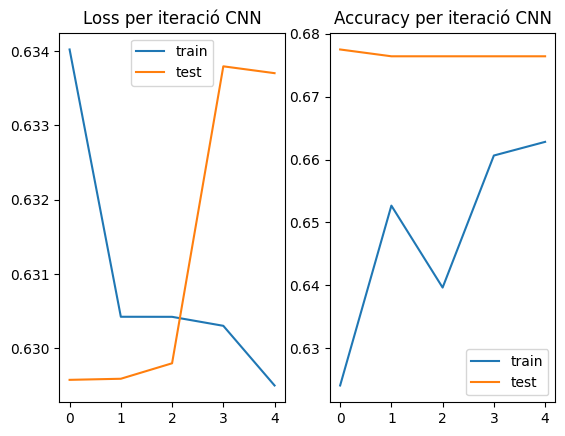

In [42]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()